# *Import Libraries:*

In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A

from sklearn.model_selection import train_test_split

# *Configurations:*

In [2]:
DATA_PATH = "Dataset/"

IMG_SIZE = 256

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data_path = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_path.extend([image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
df = pd.DataFrame({"path" : data_path})

length = df['path'].apply(lambda x: len(x)).max()
pd.options.display.max_colwidth = length+4

df.head()

This is not a dir: Dataset\data.csv
This is not a dir: Dataset\README.md


,path
0,Dataset\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
1,Dataset\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif
2,Dataset\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif
3,Dataset\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif
4,Dataset\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif


In [4]:
# Masks/Not masks
images = df[~df['path'].str.contains("mask")]['path'].reset_index(drop=True)
masks = df[df['path'].str.contains("mask")]['path'].reset_index(drop=True)

# Data sorting
images = sorted(images, key=lambda x : int(x[52:-4])) # Dataset\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_ ->...<- .tif
masks = sorted(masks, key=lambda x : int(x[52:-9])) # Dataset\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_ ->...<- _mask.tif

# Sorting check
idx = random.randint(0, len(images)-1)
print(f"Path to the Image: {images[idx]} \nPath to the Mask: {masks[idx]}")

Path to the Image: Dataset\TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_5.tif 
Path to the Mask: Dataset\TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_5_mask.tif


In [5]:
df = pd.DataFrame({"image_path" : images,
                   "mask_path" : masks})
df

,image_path,mask_path
0,Dataset\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,Dataset\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif
1,Dataset\TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif,Dataset\TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_mask.tif
2,Dataset\TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,Dataset\TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_mask.tif
3,Dataset\TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,Dataset\TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif
4,Dataset\TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif,Dataset\TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_mask.tif
...,...,...
3924,Dataset\TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86.tif,Dataset\TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86_mask.tif
3925,Dataset\TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87.tif,Dataset\TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87_mask.tif
3926,Dataset\TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87.tif,Dataset\TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87_mask.tif
3927,Dataset\TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88.tif,Dataset\TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88_mask.tif


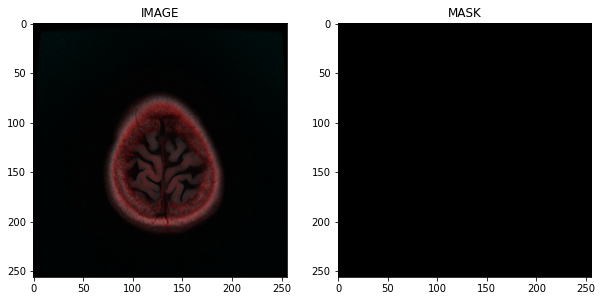

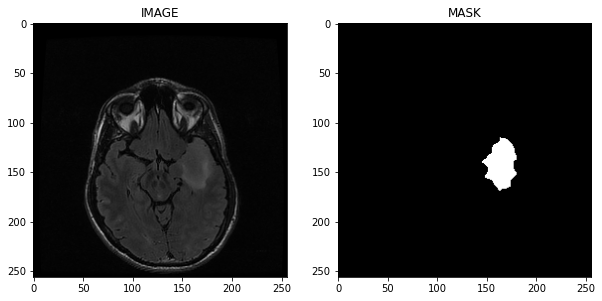

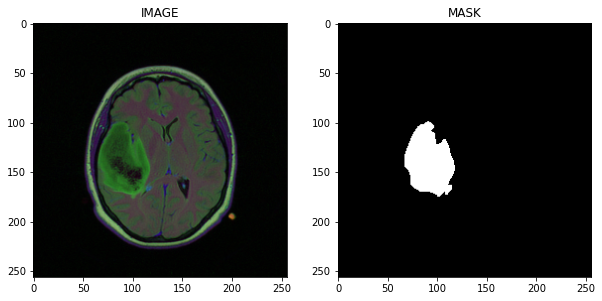

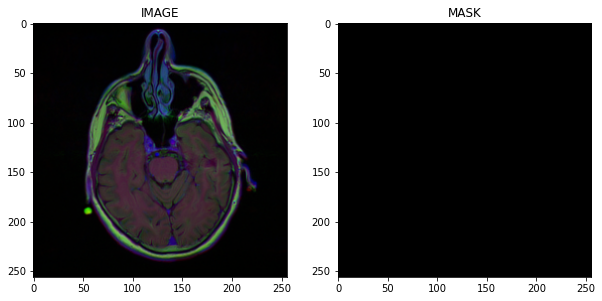

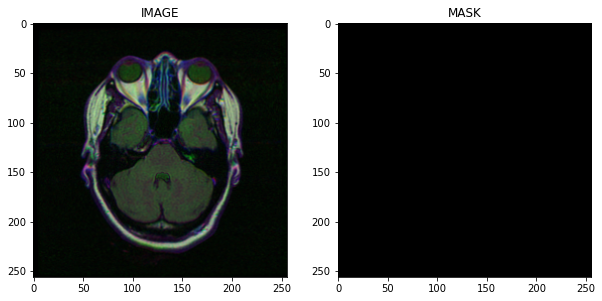

In [6]:
for i in range(5):
    idx = random.randint(0, len(images)-1)
    image = cv2.imread(df.image_path[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(df.mask_path[idx])

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

    ax1.set_title('IMAGE')
    ax1.imshow(image)

    ax2.set_title('MASK')
    ax2.imshow(mask)

If the value of the mask is greater than 0 (Black), then the patient has a abnormality tumor!

In [7]:
def diagnosis(mask):
    x = np.max(cv2.imread(mask))
    if x > 0: return 1
    else: return 0
    
df["diagnosis"] = df["mask_path"].apply(lambda x: diagnosis(x))

df.head()

,image_path,mask_path,diagnosis
0,Dataset\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,Dataset\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif,0
1,Dataset\TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif,Dataset\TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_mask.tif,0
2,Dataset\TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,Dataset\TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_mask.tif,0
3,Dataset\TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,Dataset\TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif,0
4,Dataset\TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif,Dataset\TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_mask.tif,0


In [8]:
x = df.diagnosis.value_counts()
positives = x[1] 
negatives = x[0]
print('The number of patients with abnormally tumors:')
print(f"Positives: {positives} \nNegatives: {negatives}")

The number of patients with abnormally tumors:
Positives: 1373 
Negatives: 2556


# *Augmentation:*

In [9]:
transforms = A.Compose([
    A.Resize(width = IMG_SIZE, height = IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
#     A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),
    
    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    ], p=0.8),
])

# *Custom Dataset:*

In [11]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image = cv2.imread(row.image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(row.mask_path)

        if self.transforms:
            data = self.transforms(image = image, mask = mask)
            image = data['image']
            mask = data['mask']

        # (h, w, c) -> (c, h, w)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.Tensor(image) / 255.
        mask = torch.round(torch.Tensor(mask) / 255.)
        
        return image, mask

In [12]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

print(f"Train Shape: {train_df.shape} \nVal Shape: {val_df.shape} \nTest Shape: {test_df.shape}")

Train Shape: (3005, 3) 
Val Shape: (393, 3) 
Test Shape: (531, 3)


# *Load Dataset:*

In [13]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, shuffle=True)

In [14]:
def show_image(image, mask, pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('MASK')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('MASK')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

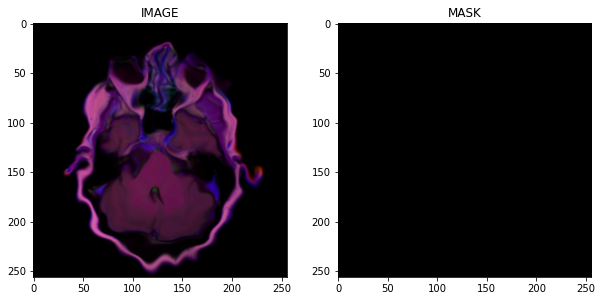

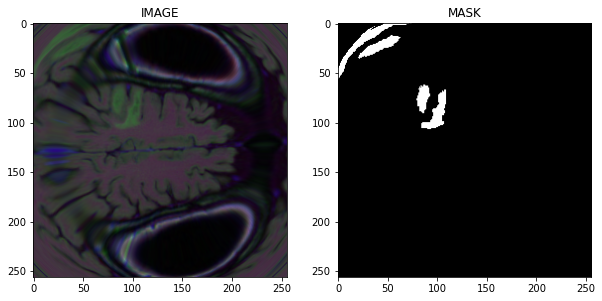

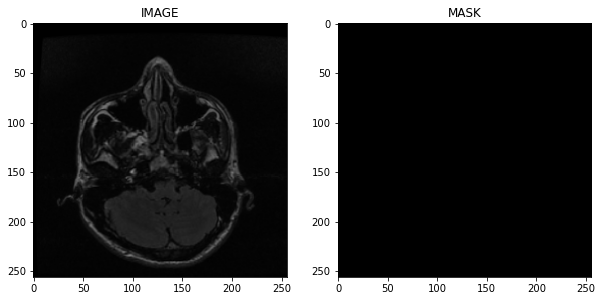

In [15]:
for i in range(3):
    idx = random.randint(0, len(train_dataset)-1)
    image, mask = train_dataset[idx]
    show_image(image, mask)

In [16]:
image, mask = next(iter(train_dataloader))
print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([26, 3, 256, 256])
One batch mask shape : torch.Size([26, 3, 256, 256])


# *Create Model:*

In [33]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU())

In [34]:
class UNet(nn.Module):
    
    def __init__(self, n_classes):
        super().__init__()
        
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128)
        self.conv_up1 = double_conv(64 + 128, 64)
        
        self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
    
    def forward(self, x):
        
        conv1 = self.conv_down1(x)  
        x = self.maxpool(conv1)  
        
        conv2 = self.conv_down2(x)
        x = self.maxpool(conv2)  
        
        conv3 = self.conv_down3(x) 
        x = self.maxpool(conv3)
        
        x = self.conv_down4(x)     
        x = self.upsample(x)     
        x = torch.cat([x, conv3], dim=1) 
        
        x = self.conv_up3(x)  
        x = self.upsample(x)  
        x = torch.cat([x, conv2], dim=1)

        x = self.conv_up2(x)
        x = self.upsample(x)      
        x = torch.cat([x, conv1], dim=1) 
        
        x = self.conv_up1(x) 
        
        out = self.last_conv(x) 
        out = torch.sigmoid(out)
        
        return out

In [36]:
unet = UNet(n_classes=1).to(DEVICE)
output = unet(torch.randn(1,3,256,256).to(DEVICE))
print("",output.shape)

 torch.Size([1, 1, 256, 256])
